<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/RedesNeuronales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fuente: https://github.com/s3131212/dga-detection
LSTM +Conv1D
159806 parámetros

Datos: 

- Malignos: Netlab360
- Benignos: Tranco List (Del 20/4/2020 al 20/6/2020)


In [23]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [24]:
# Estilos seaborn
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

In [25]:
# Cargamos datos
GDRIVE_PATH='/content/drive/MyDrive/TFM'
DATASET_PATH=os.path.join(GDRIVE_PATH, 'data_processed/dga.csv')
IMAGES_PATH=os.path.join(GDRIVE_PATH, 'img')
CHECKPOINTS_PATH=os.path.join(GDRIVE_PATH, 'checkpoints')

df = pd.read_csv(DATASET_PATH,index_col=0)

In [26]:
df.sample(10)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc
325171,fybcmsgobr.com,dnschanger,malign,com,fybcmsgobr,3,0,10,0,3.121928,0.111111
474052,f840a139.eu,ekforward,malign,eu,f840a139,3,6,8,0,3.000000,0.142857
238480,pmbyekcpeturpoye.com,sphinx,malign,com,pmbyekcpeturpoye,3,0,16,0,3.280639,0.454545
950661,grahakomindo.net,benign,benign,net,grahakomindo,3,0,12,0,3.251629,0.714286
994321,billlevkoff.com,benign,benign,com,billlevkoff,3,0,11,0,2.845351,0.375000
124751,fukuovorlwguf62bvp32lvo61lwn30gqdzf22.ru,murofetweekly,malign,ru,fukuovorlwguf62bvp32lvo61lwn30gqdzf22,3,10,37,0,4.134469,0.193548
529264,omtyeck.info,shifu,malign,info,omtyeck,3,0,7,0,2.807355,0.400000
89746,06382617.top,infy,malign,top,06382617,3,8,8,0,2.750000,0.000000
31964,kf56kf5refe87ja0mpqj7vg.ddns.net,corebot,malign,net,ddns,3,0,4,0,1.500000,0.000000
721353,rentreediscount.com,benign,benign,com,rentreediscount,3,0,15,0,3.189898,0.666667


In [27]:
# Para probar el código tomamos un 10% del dataset original (aprox 10.000)
# Realizamos una muestra estratificada para que haya muestras de todas las familias

df=df.groupby('family', group_keys=False).apply(lambda x: x.sample(frac=0.5))
df.shape

(571267, 11)

In [28]:
X = np.array(df['domain'])

# Codificamos como 0 los dominios benignos y como 1 los malignos
Y = np.array([0 if x == 'benign' else 1 for x in df['category']])

# Obtiene un set (elementos únicos) de todos los caracteres utilizados en todos los dominios
# No hay ningún criterio para la ordenación, se asignan números según aparecen los caracteres.
valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}
# Se le suma 1 para UNKNOWN
max_features = len(valid_chars) + 1
# Se determina max_len como el dominio mas largo del dataset. 
# Se puede optar por fijarlo al valor especificado en el RFC
# La longitud máxima de un dominio es de 255 caracteres (incluyendo TLD, SLD, ...)
# RFC 1035 section 2.3.4.
max_len = max([len(i) for i in X])

# Recorre todos los caracteres de todos los dominios y los sustituye por su equivalente numérico
X = [[valid_chars[y] for y in x] for x in X]

# Añade padding hasta la máxima longitud
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len)

# Dividimos el dataset en training (80%) y test (20%). 
# Utilizamos una semilla para poder reproducir los resultados
# Hacemos un muestreo estratificado de acuerdo al atributo 'family'
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42, stratify=df['family'])


In [29]:
LOSS_FUNCTION='binary_crossentropy'
OPTIMIZER='nadam'
METRICS=['accuracy']

In [30]:
def plot_model(history,title):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['train', 'validate'])
  plt.title(title)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')

In [31]:
def get_cm_metrics(model, x_test, y_test):
  y_test_pred = model.predict(x_test)

  # Confusion matrix
  cm=confusion_matrix(y_test, y_test_pred > .5)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

  # Classification report
  print(classification_report(y_test, y_test_pred > .5))

  # ROC
  fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
  roc_auc = auc(fpr, tpr)
  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()


In [32]:
def get_ANN(max_features, max_len, loss_function, optimizer):
  '''
  Red neuronal monocapa formada por 100 neuronas
  '''
  
  model = Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    layers.Dense(128, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
  ])

  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  return model

In [33]:
def get_DNN(max_features, max_len, loss_function, optimizer):
  '''
  Red neuronal multicapa. Dos capas de 50 neuronas.
  '''
  model = Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
  ])

  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  return model

In [34]:
def get_LSTM(max_features, max_len, loss_function, optimizer):

  model = Sequential([
    layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len),
    layers.LSTM(128, return_sequences=True),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.LSTM(64),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')    
  ])
  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  return model

In [35]:
def get_Conv1D(max_features, max_len, loss_function, optimizer):
  '''
  Proporciona un modelo CNN Conv1D con una única capa convolucional con 
  30 filtros de tamaño de kernel 4.
  '''
  model = Sequential()
  model.add(layers.Embedding(input_dim=max_features, output_dim=128, input_length=max_len))

  model.add(layers.Conv1D(30, 4, activation='relu'))
  model.add(layers.GlobalMaxPooling1D())

  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(1))
  model.add(layers.Activation('sigmoid'))
  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  tf.keras.utils.plot_model(model, to_file=os.path.join(IMAGES_PATH,'Conv1D.png'), show_shapes=True)
  
  return model

In [36]:
def get_LSTM_Conv1D(max_features, max_len, loss_function, optimizer):
  domain_input = tf.keras.Input(shape = (max_len,), name='text_input')
  input_layer = layers.Embedding(max_features, 128, input_length=max_len)(domain_input)

  lstm = layers.LSTM(128)(input_layer)
  lstm = layers.Dropout(0.5)(lstm)
  lstm = layers.Dense(1)(lstm)
  block_lstm_output = layers.Activation('sigmoid')(lstm)

  # 15 filtros, kernels de distintos tamaños: 2, 4 y 6. Algo similar a ngrams

  # Chollet:
  # A 1D convnet processing sequences of characters using convolution windows 
  # of size 5 should be able to learn words or word fragments of length 5 or less
  #
  conv_a = layers.Conv1D(15,2, activation='relu')(input_layer)
  pool_a = layers.GlobalMaxPooling1D()(conv_a)

  conv_b = layers.Conv1D(15,4, activation='relu')(input_layer)
  pool_b = layers.GlobalMaxPooling1D()(conv_b)

  conv_c = layers.Conv1D(15,6, activation='relu')(input_layer)
  pool_c = layers.GlobalMaxPooling1D()(conv_c)

  flattened = layers.add([pool_a, pool_b, pool_c])
  drop = layers.Dropout(0.5)(flattened)

  block_cnn_output = layers.Dense(1, activation='sigmoid')(drop)

  output = layers.add([block_lstm_output, block_cnn_output])

  model = tf.keras.Model(domain_input, output)
  model.summary()

  model.compile(loss=loss_function, optimizer=optimizer, metrics=['accuracy'])
  
  tf.keras.utils.plot_model(model, to_file=os.path.join(IMAGES_PATH,'LSTM_Conv1D.png'), show_shapes=True)

  return model

# Hiperparámetros, funciones de activación...

¿Pq ann/dnn potencias de 2: 2,8,16,64,...? 
En teoría convergen más rápido, pero sólo debería ser para CNN:
https://ai.stackexchange.com/questions/5399/why-should-the-number-of-neurons-in-a-hidden-layer-be-a-power-of-2

¿Por qué 128  en la capa de embedding?

¿Por qué batch size de 128?

¿Por qué 100 epochs?

¿Por qué 0.2 o 0.5 en la capa Dropout? La capa de dropout sirve para evitar el overfitting

¿Por qué 30 filtros en Conv1D? 

¿Por qué kernel size de 4?

¿En Conv1D por qué capas paralelas en lugar de consecutivas?

Utilizar grid search en Keras: https://towardsai.net/p/l/stop-using-grid-search-the-complete-practical-tutorial-on-keras-tuner



In [37]:
# Array donde guardaremos las métricas y tiempos de cada modelo para compararlos
metrics=[]
def train_model_get_metrics(model_name, model):
  cp_path=os.path.join(CHECKPOINTS_PATH,model_name)
  # Callbacks: Checkpoint
  checkpoint = tf.keras.callbacks.ModelCheckpoint(cp_path, 
                                                  save_weights_only=True,
                                                  monitor='val_loss',
                                                  mode='min',
                                                  save_best_only=True)
  # El entrenamiento se detiene si tras tres epoch (patience=3) no se reduce el mejor val_loss
  earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

  # Entrenamiento del modelo
  start=timer()
  history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_split=0.1, callbacks=[earlyStopping,checkpoint])
  end = timer()
  t=end-start

  # Cargamos el checkpoint del mejor modelo y evaluamos con el conjunto de test
  model.load_weights(cp_path)
  loss, acc = model.evaluate(x_test, y_test, verbose=2)

  # Recopilamos métricas, número de parámetros de la red y tiempo de ejecución
  metrics.append([model_name,acc,loss,model.count_params(),t])
  # Dibujamso 
  plot_model(history,'Accuracy modelo '+model_name)
  get_cm_metrics(model, x_test, y_test)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 66, 128)           4992      
                                                                 
 dense_4 (Dense)             (None, 66, 128)           16512     
                                                                 
 flatten_2 (Flatten)         (None, 8448)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8448)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 8449      
                                                                 
Total params: 29,953
Trainable params: 29,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3214/3214 [===========================

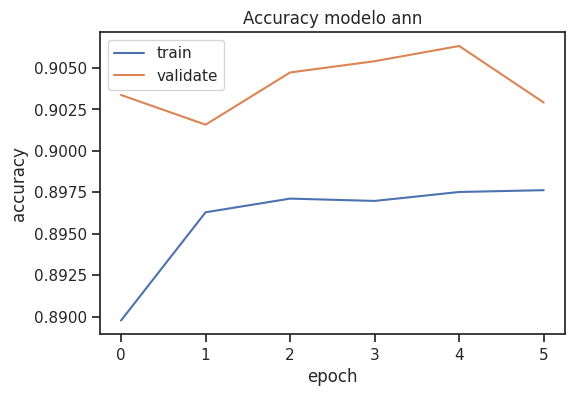

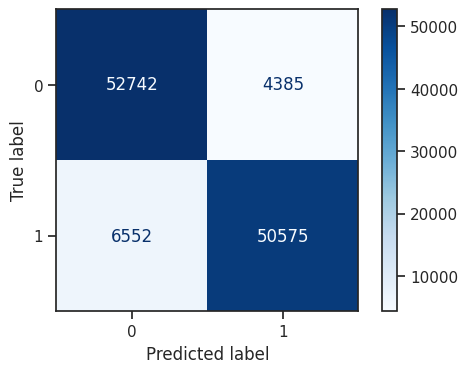

              precision    recall  f1-score   support

           0       0.89      0.92      0.91     57127
           1       0.92      0.89      0.90     57127

    accuracy                           0.90    114254
   macro avg       0.90      0.90      0.90    114254
weighted avg       0.90      0.90      0.90    114254



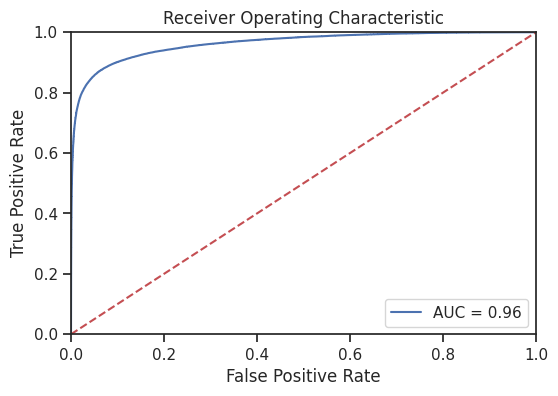

In [38]:
#@title Modelo ANN (monocapa)
train_model_get_metrics(model_name='ann',model=get_ANN(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 66, 128)           4992      
                                                                 
 dense_6 (Dense)             (None, 66, 64)            8256      
                                                                 
 flatten_3 (Flatten)         (None, 4224)              0         
                                                                 
 dropout_3 (Dropout)         (None, 4224)              0         
                                                                 
 dense_7 (Dense)             (None, 64)                270400    
                                                                 
 flatten_4 (Flatten)         (None, 64)                0         
                                                                 
 dropout_4 (Dropout)         (None, 64)               

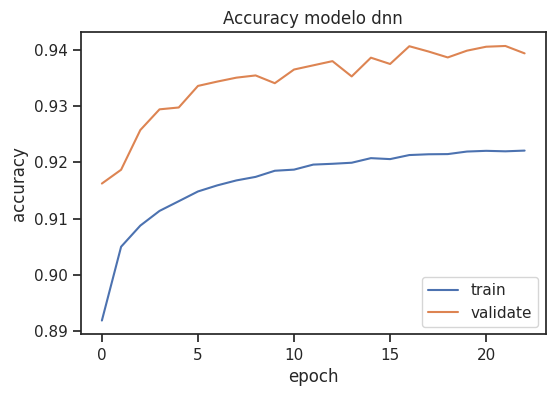

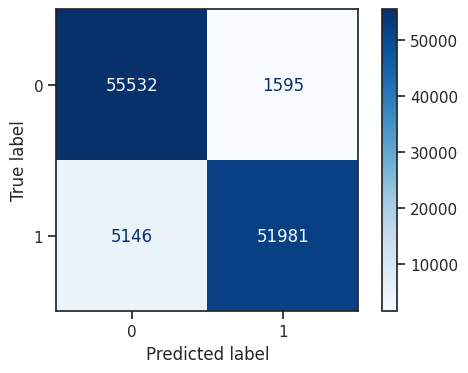

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     57127
           1       0.97      0.91      0.94     57127

    accuracy                           0.94    114254
   macro avg       0.94      0.94      0.94    114254
weighted avg       0.94      0.94      0.94    114254



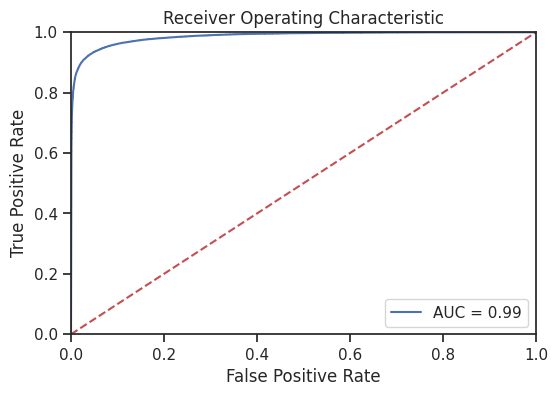

In [39]:
#@title Modelo DNN (multicapa)
train_model_get_metrics(model_name='dnn',model=get_DNN(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 66, 128)           4992      
                                                                 
 lstm (LSTM)                 (None, 66, 128)           131584    
                                                                 
 dropout_5 (Dropout)         (None, 66, 128)           0         
                                                                 
 dense_9 (Dense)             (None, 66, 64)            8256      
                                                                 
 dropout_6 (Dropout)         (None, 66, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_7 (Dropout)         (None, 64)               

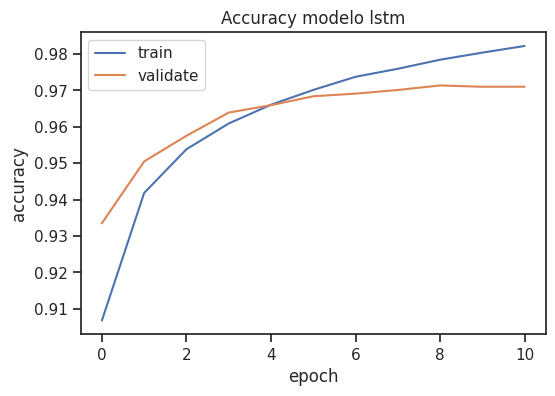

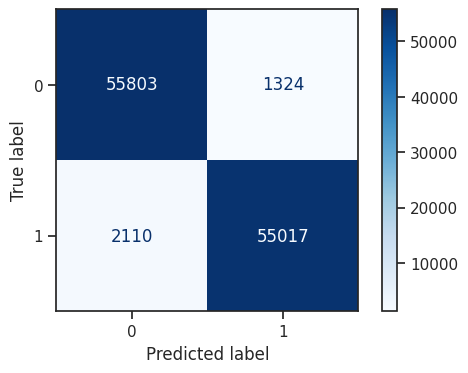

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     57127
           1       0.98      0.96      0.97     57127

    accuracy                           0.97    114254
   macro avg       0.97      0.97      0.97    114254
weighted avg       0.97      0.97      0.97    114254



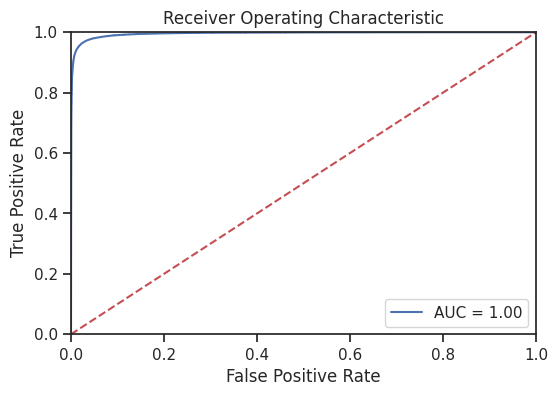

In [40]:
#@title Modelo RNN (LSTM)
train_model_get_metrics(model_name='lstm',model=get_LSTM(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 66, 128)           4992      
                                                                 
 conv1d (Conv1D)             (None, 63, 30)            15390     
                                                                 
 global_max_pooling1d (Globa  (None, 30)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_8 (Dropout)         (None, 30)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                      

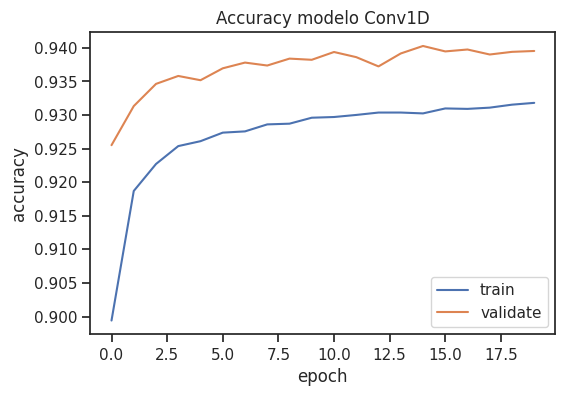

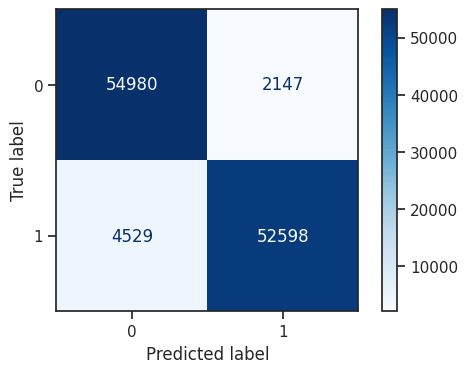

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     57127
           1       0.96      0.92      0.94     57127

    accuracy                           0.94    114254
   macro avg       0.94      0.94      0.94    114254
weighted avg       0.94      0.94      0.94    114254



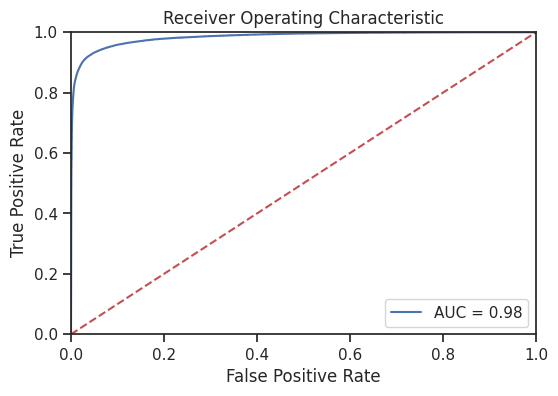

In [41]:
#@title Modelo CNN (Conv1D)
train_model_get_metrics(model_name='Conv1D',model=get_Conv1D(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 66)]         0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 66, 128)      4992        ['text_input[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)              (None, 65, 15)       3855        ['embedding_6[0][0]']            
                                                                                                  
 conv1d_2 (Conv1D)              (None, 63, 15)       7695        ['embedding_6[0][0]']            
                                                                                              

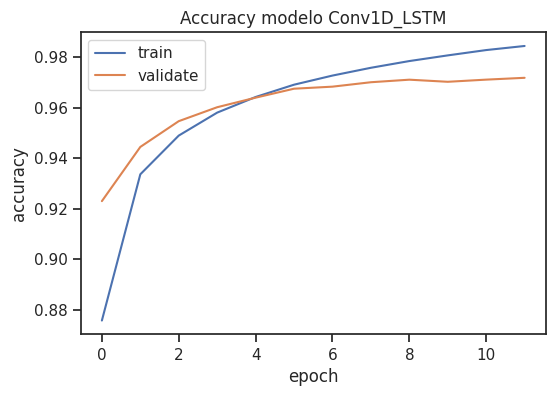

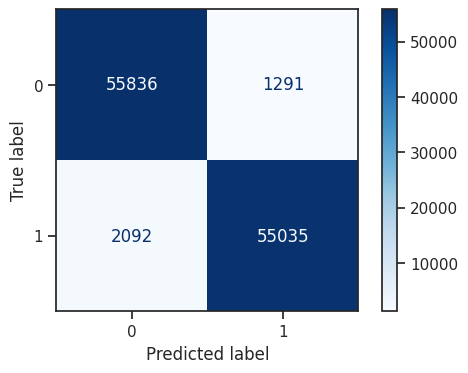

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     57127
           1       0.98      0.96      0.97     57127

    accuracy                           0.97    114254
   macro avg       0.97      0.97      0.97    114254
weighted avg       0.97      0.97      0.97    114254



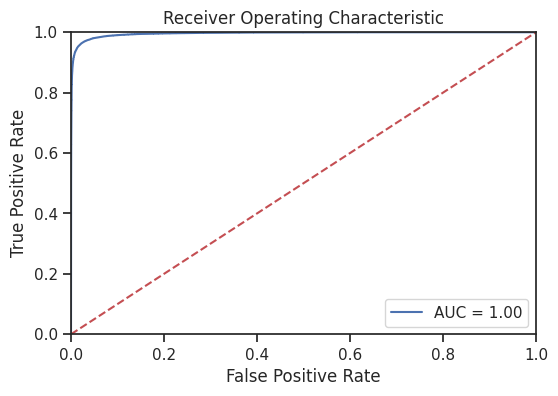

In [42]:
#@title Modelo mixto LSTM-Conv1D
train_model_get_metrics(model_name='Conv1D_LSTM',model=get_LSTM_Conv1D(max_features,max_len,LOSS_FUNCTION,OPTIMIZER))

In [43]:
metrics

[['ann', 0.9042747020721436, 0.2407020777463913, 29953, 95.09318118899989],
 ['dnn', 0.9409998655319214, 0.15489532053470612, 283713, 388.561071941],
 ['lstm', 0.969944179058075, 0.08592566847801208, 177921, 542.468155993],
 ['Conv1D',
  0.9415687918663025,
  0.15562430024147034,
  20413,
  334.47634456599985],
 ['Conv1D_LSTM',
  0.9703905582427979,
  0.08364345133304596,
  159806,
  479.1218817920003]]

In [44]:
metrics_df = pd.DataFrame(data=metrics, columns=['modelo', 'accuracy', 'loss','parametros','tiempo entrenamiento'])
metrics_df

,modelo,accuracy,loss,parametros,tiempo entrenamiento
0,ann,0.904275,0.240702,29953,95.093181
1,dnn,0.941000,0.154895,283713,388.561072
2,lstm,0.969944,0.085926,177921,542.468156
3,Conv1D,0.941569,0.155624,20413,334.476345
4,Conv1D_LSTM,0.970391,0.083643,159806,479.121882
